<a href="https://colab.research.google.com/github/piziomo/Trainings/blob/main/RNNs_2025_Training_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Week 05: Introduction to Recurrent Neural Networks

In the previous lab (week 04) we generated images using generative adversarial networks (GANs). This week we will shift our focus to *text* generation. For this task, we will build a neural network model based on the recurrent neural network architecture, using a dataset of writing from Warwickshire's own Shakespeare.

What do you think: which text (on the left or right) was generated with an RNN model that we will build today?

|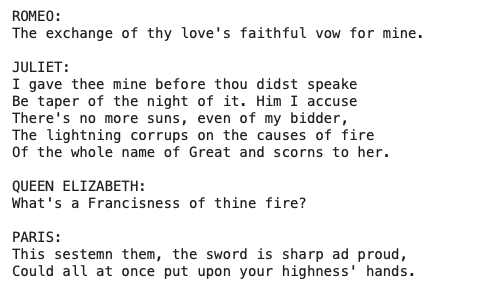 |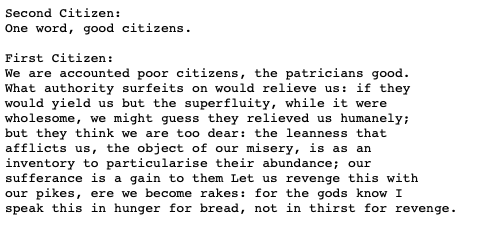



# Introduction

**Why do we need another type of neural network?**
For image generation, we relied on convolutional neural networks (or "convnets"). You might remember that convnets have two advantages over a single or multi-layer perceptron:

1. Convnets are translation-invariant.
2. Convnets can learn spatial hierarchies.

These advatanges, however, do not necessarily hold when working with text data. As Foster (2023) notes, working with image and text data differs in the following ways:

1. Text data is composed of discrete chunks (characters or words) while pixels in an image are points in a continuous colour spectrum.
  - For example, in a grayscale image you can make a particular pixel more black or white by changing its numeric value, but it is not clear how you could make word "cat" more like the word "dog".
2. Text data, contrary to images, has a temporal (time) dimension but no spatial dimensions.
  - Images can be rotated, flipped, etc. without affecting the content, but the sequence of characters and words is essential for our text understanding.
3. Text data is more sensitive to small changes in the individual units.
  - A change in a particular pixel is unlikely to make an image unrecognizable, however changing a character in a word might alter the meaning. For instance, changing "o" to "i" in the "dog" would result in a word having a very different meaning, i.e. "dig".
4. Text data is often said to conform to a rules-based grammatical structure (i.e. "syntax"), but there are no rules, for example, for assigning pixel values in an image.

**A recurrent neural network** (RNN) is an autoregressive model. This means that an output depends on a sequence of previous inputs.

 can handle text data or other types of sequential data, such as time series. This is because they iterate through a sequence of elements (an internal 'for' loop) while "remembering" what it has seen before. You could say that RNNs have memory which is needed to process text data. Because of the continuous reuse of the memory, it is called *recurrent* (not recursive!).


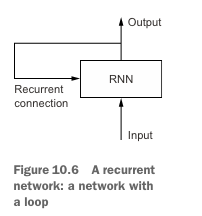

The need for memory makes sense if you think how humans read -- one word (or character) at a time, but each word is related to the previously seen words in order to make sense of the text in front of you. Thus, you need to remember what you have already read.

For convnets, however, you would have to show an entire sequence at once because they have no memory. In other words, we would have to turn our text data into a single data point.

# Data preparation

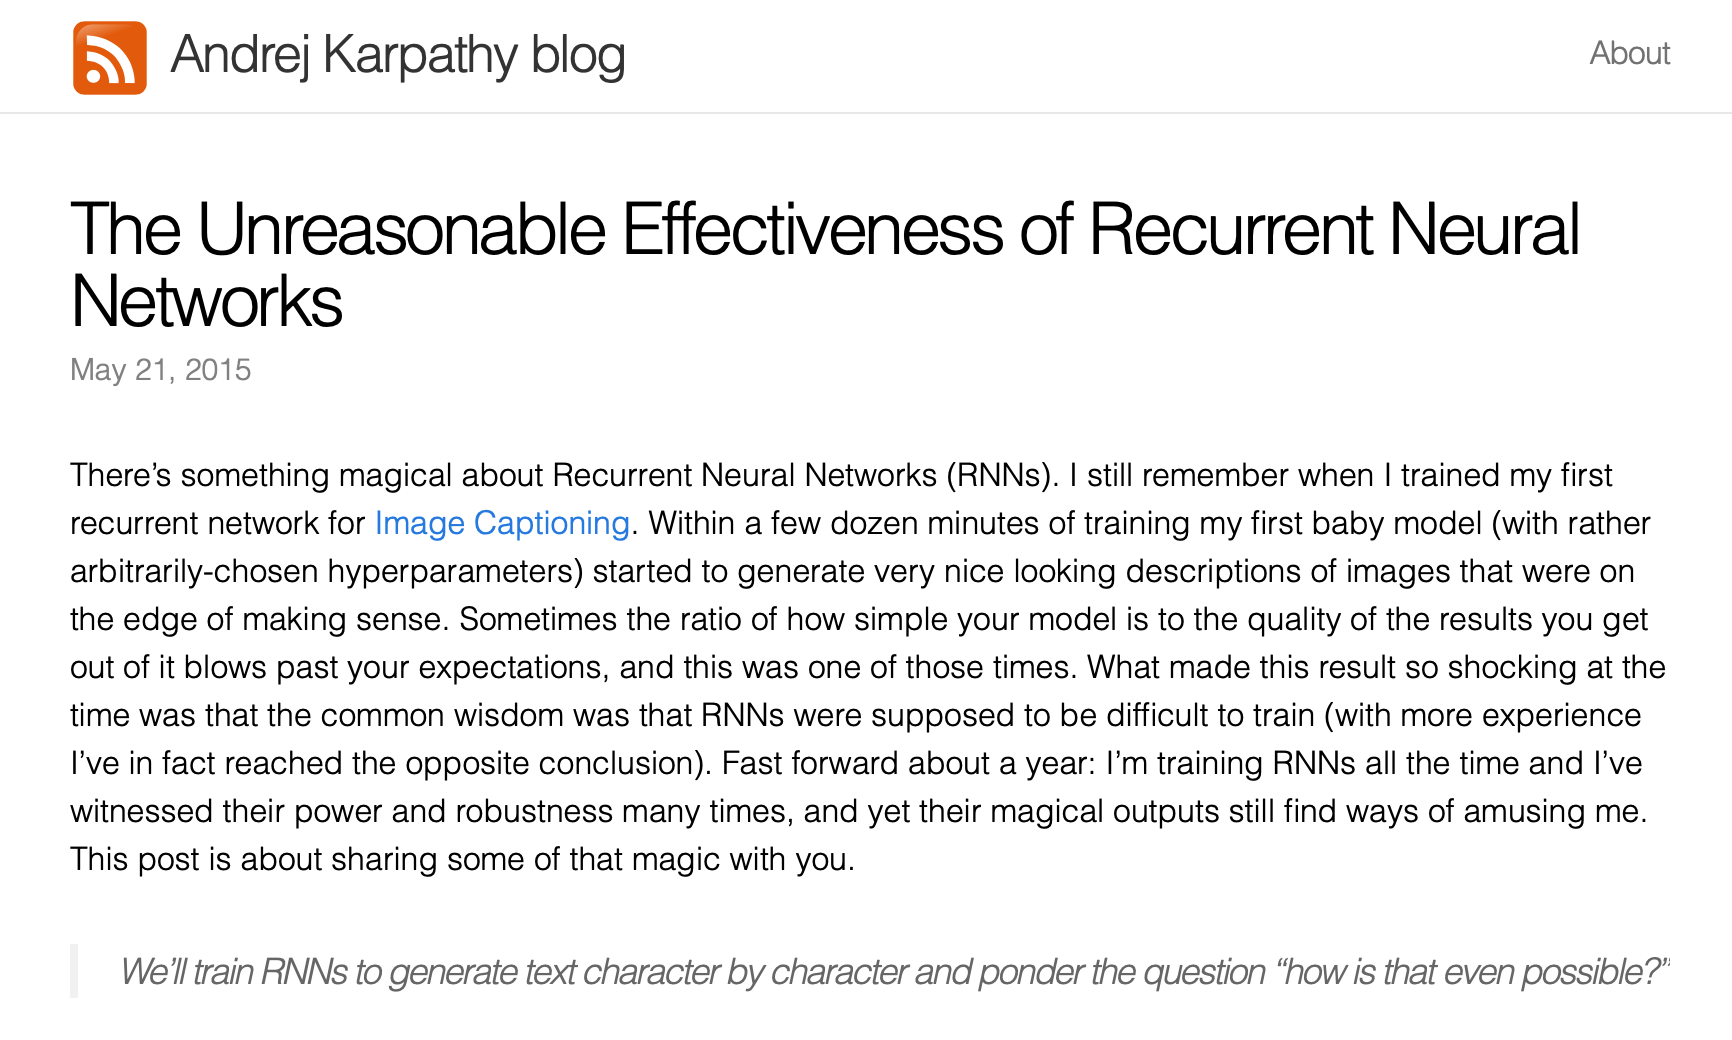

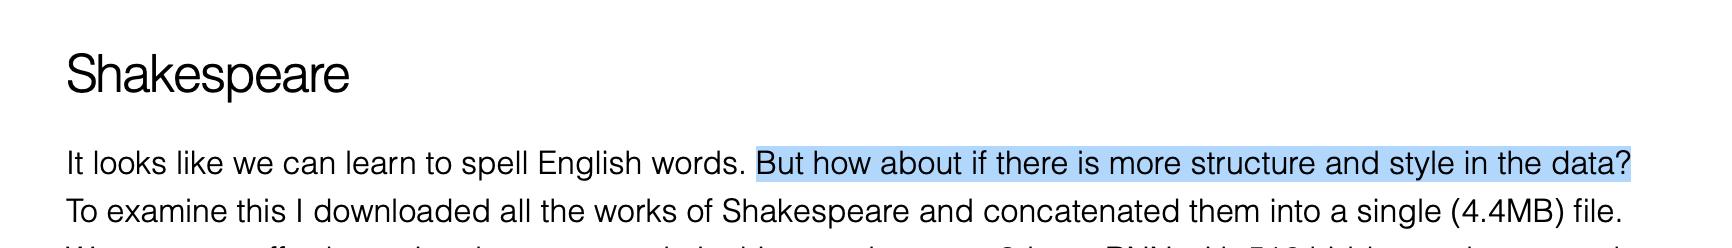

In [ ]:
import numpy as np
import re # import a module for regular expressions matching operations
import string # import a module for string (text) operations
import os
import time

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, losses

In [ ]:
# Download the Shakespeare dataset
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Read in the data
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# look at the first 250 characters to make sure it was read in as expected
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# You can also find out the number of unique **characters** in our dataset

vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')
print(vocab)

# Note: '\n' refers to a new line/paragraph

65 unique characters
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Lookup table



Look up table is a dictionary which contains value-key pairs. An example of it can be found in the optional "Autoencoders" lab.

In this lab, we will also create such dictionary to assign an integer token to each unique character in our dataset.

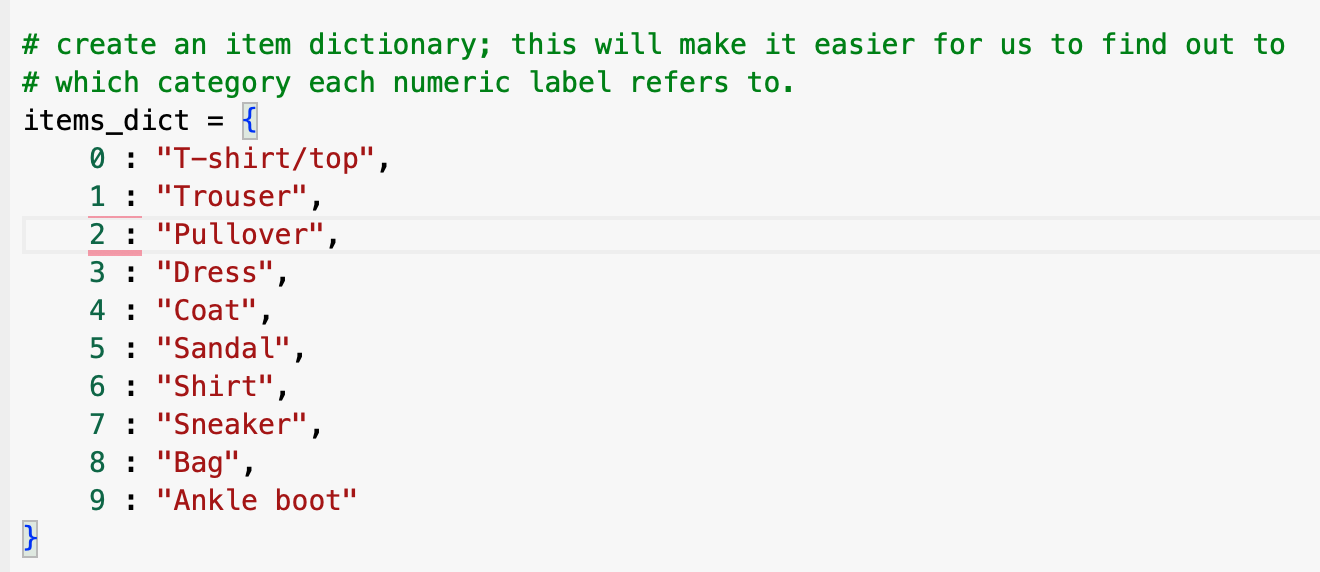

In [ ]:
# create a lookup table that will map character inputs to numeric outputs
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

# convert text to a numeric representation
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))

In [ ]:
print(text[:13])
print(all_ids[:13])
print(ids_from_chars.get_vocabulary())

# Note: [UNK] is used for characters or words outside of vocabularly.
# This would be important if we had trimmed our training dataset to contain
# only, for example, the most common 50 characters.

First Citizen
tf.Tensor([19 48 57 58 59  2 16 48 59 48 65 44 53], shape=(13,), dtype=int64)
['[UNK]', '\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


So far, we encoded our input text numerically, so we can train our model. But our model will output numbers, not text. To make the output readable, we will need to convert it back to text.

In [ ]:
# function to converting a numeric representation to text
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

print(tf.strings.reduce_join(chars_from_ids(all_ids[:21]), axis=-1).numpy())

b'First Citizen:\nBefore'


## Creating sequences

To train our model, we will need to provide *sequences* of data, so it can be looped over.

The sequence is a collection of multiple samples (here, characters) whose order matters. It is also what we will iterate over to train the model to predict the character.

Each element in the sequence is often referred to as a time step, which makes sense when working with time series data, but perhaps is less intuitive when applied to text data. Nevertheless, you could think of it as something that emphasises the importance of order in which something is done (e.g. order words matters to construct an intelligible sentence).

**Why do we need to provide sequences of data and how does training happen?**

First, our RNN model will be trained on sequences of 100 characters. You could train a model on shorter or longer sequences, you have to experiment to see what works.


In [ ]:
# print the first 100 characters. This is an example of a sequence.
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


Second, our RNN model will be trained to predict 101th character. It is called a *target* character. However, our sequence length is 100 characters. Thus, we need another sequence of 100 characters to train our model.

Our model will be penalised depending on whether it guessed the correct *first* character in the following sequence of 100 characters or not.

In [ ]:
# let's print out an example of our second sequence. The target, which needs to
# be predicted by the end of sequence 1 is the character 'a'.
print(text[101:200])

are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


The RNN model will be trained on sequences of 100 characters. If we use sequences of 100 characters, how can we train our model to generate text?

First, the RNN model will be trained by predicting the character that appears after the sequence it has "seen", i.e. 101th character. To do this, we will need to create a *target* sequence which will contain the 101th element. BUT remember that our sequence length must be equal to 100 characters. How can we do this? By creating a sequence of 101 characters which, then, is split into an input sequence and a target sequence.

In [ ]:
# Sequence length (this can be of any length, so feel free to experiment)
seq_length = 100

ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

sequences = ids_dataset.batch(
    seq_length+1, # increasing sequence length because we will be predicting the 101st character (after every 100 charaters)
    drop_remainder=True)
print(len(sequences))

11043


In [ ]:
# Now we can work with sequences of characters.
# For example, we can convert a numeric sequence to text

def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

for seq in sequences.take(1):
  print(text_from_ids(seq).numpy())
  print(len(text_from_ids(seq).numpy()))

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
101


In [ ]:
# We have constructed sequences of characters. Now let's
# define input sequence and target sequence, which has the correct character
# that our model will have to predict
def split_input_target(sequence):
    input_text = sequence[:-1] # input sequence length
    target_text = sequence[1:] # for predicting the last character in the sequence
    return input_text, target_text

In [ ]:
# create a dataset with sequences
dataset = sequences.map(split_input_target)

In [ ]:
# Print out an example of an input and target sequences
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


Finally, let's batch the sequences. These batches will be fed into the model for training. Before batching, we will shuffle the data (sequences, not the characters in a sequence!). Shuffling is used to improve model generalisation.

### Creating batches of sequences

In [ ]:
BATCH_SIZE = 64

# Buffer size is used to add randomness and improve generalisation.
# 64 sequences out of 10k shuffled sequences will be batched;
# then other 64 sequences will be batched out of 10k shuffled
# sequences, etc.

BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

# Model architecture

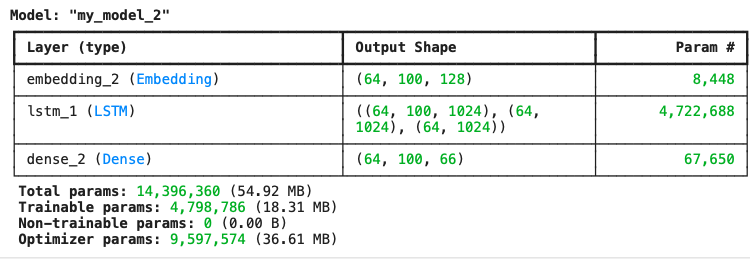

### Vectorisation: word embeddings

We created a lookup table, which will be helpful in decoding the RNN's output, but for the training, we want to represent each character in a multidimensional space. For this, we will use **word embeddings**.

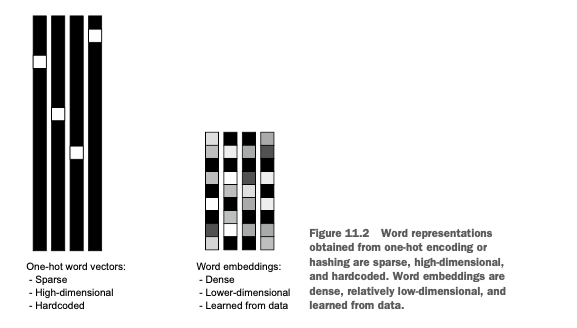

In [ ]:
# Length of the vocabulary in StringLookup Layer
# StringLookup is like a table that contains an index for each unique character in our dataset
vocab_size = len(ids_from_chars.get_vocabulary())
print(vocab_size)
print(sorted(set(text)))
print(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 128

66
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['[UNK]', '\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


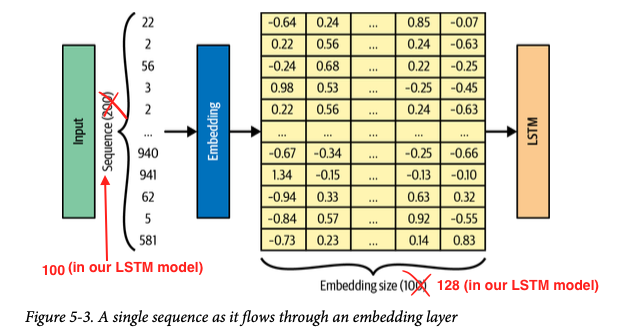

## Recurrent layer: LSTM

There are three types of recurrent layers: SimpleRNN (too basic to be effective), LSTM (Long Short Term Memory), and GRU (Gated Recurrent Units).

You will be introduced to the SimpleRNN and LSTM. (GRU is similar to LSTM, so refer to the recommended resources if you want to learn more.)

### From a simple recurrent layer

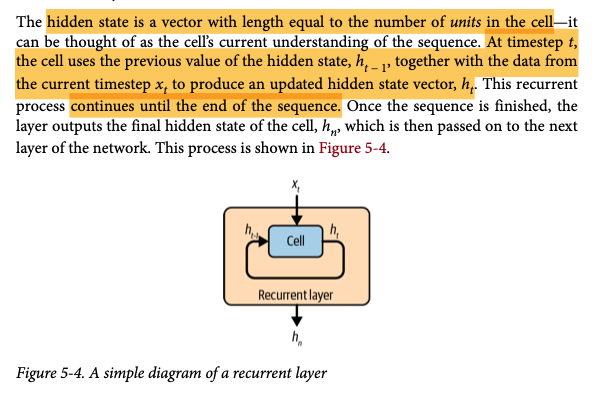



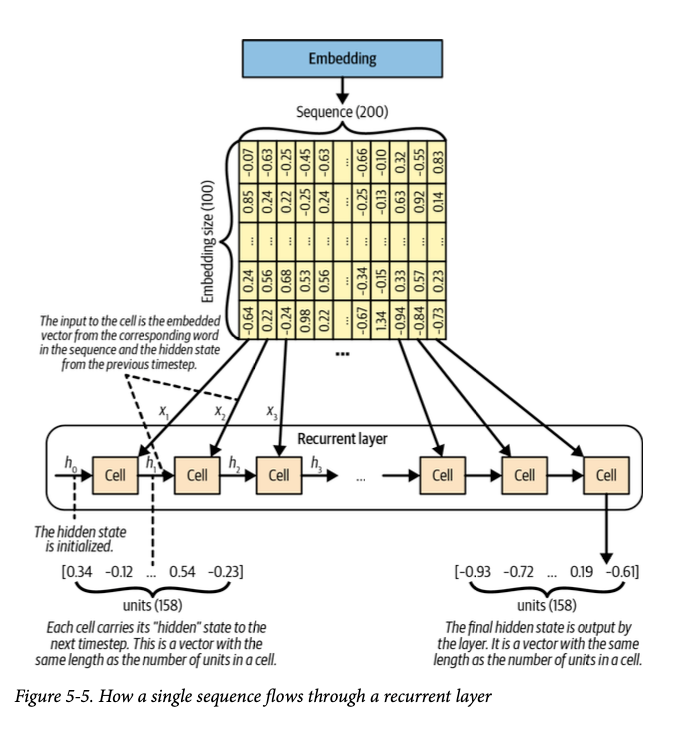

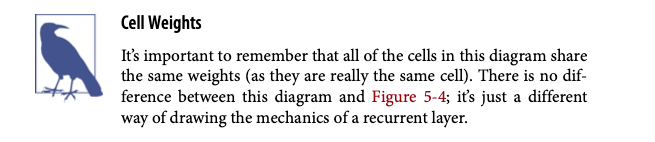

A major problem with SimpleRNNs is **vanishing gradient**. It means that a model is not able to "remember" what it has seen many timesteps ago, thus, in practice, it cannot learn about long-term dependencies.

### To LSTM

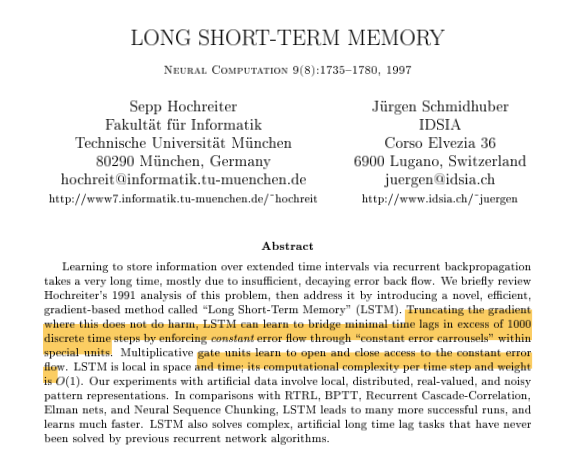



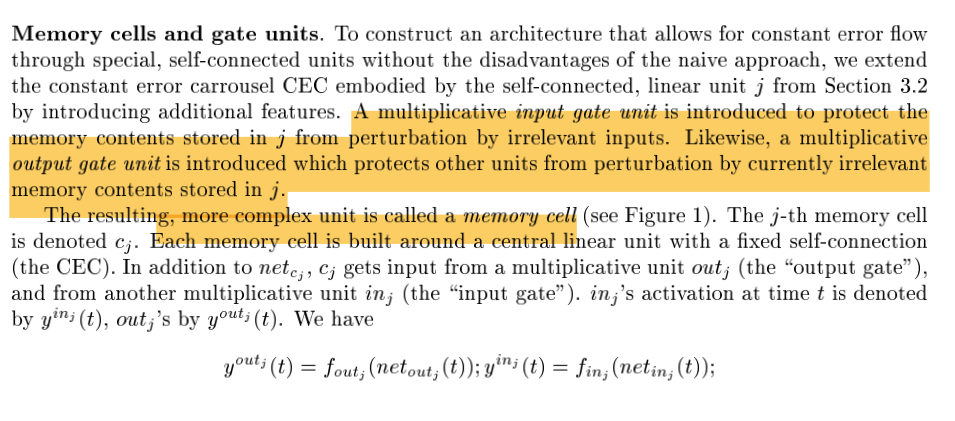

This is how Chollet (2021, p.297) describes LSTM: "This layer is a variant of the SimpleRNN layer you already know about; **it adds a way to carry information across many timesteps**. Imagine a conveyor belt running parallel to the sequence you’re processing. Information from the sequence can jump onto the conveyor belt at any point, be transported to a later timestep, and jump off, intact, when you need it. This is **essentially what LSTM does: it saves information for later, thus preventing older signals from gradually vanishing during processing.**"

Doesn't Chollet's discussion of a conveyor sound similar to Hochreiter and Schmidhuber's (1997) description of a memory cell?

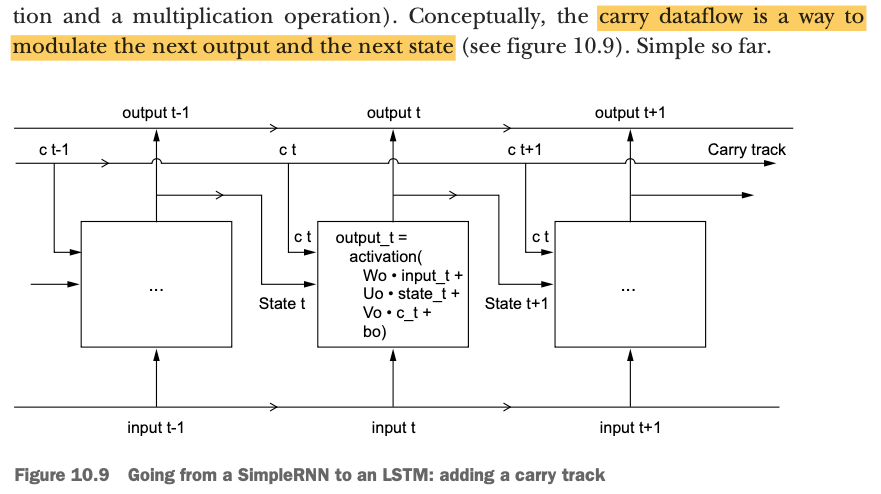

If you feel confused about what's going on in recurrent layer, don't worry too much! It's enough to understand that LSTM is a layer for processing sequence data in a way that allows a model to "remember" previous inputs of an input sequence.

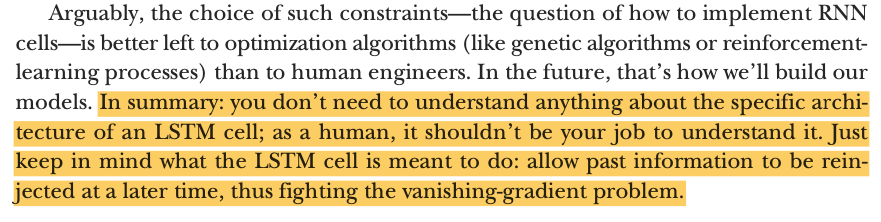

## Building the model

In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        # Explicitly call Layer.__init__ with no arguments
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(rnn_units,
                                           return_sequences=True,
                                           return_state=True)  # Changed to LSTM
        self.dense = tf.keras.layers.Dense(vocab_size)
        # store the rnn_units for easy reference for states shape.
        self.rnn_units = rnn_units

    #@tf.function
    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            # Get the batch size from the input shape
            batch_size = tf.shape(x)[0]
            # Initialize both the hidden state and cell state for the LSTM
            states = (tf.zeros((batch_size, self.rnn_units), dtype=x.dtype),  # hidden state
                      tf.zeros((batch_size, self.rnn_units), dtype=x.dtype))  # cell state

        # The LSTM layer returns (output, state_h, state_c)
        # when return_sequences=True and return_state=True.
        # We only need the output (x) and the final state (states)
        lstm_output = self.lstm(x, initial_state=states, training=training)
        x, h, c = lstm_output[0], lstm_output[1], lstm_output[2]  # Unpack LSTM output
        states = (h, c)  # Update the states to be a tuple of (hidden_state, cell_state

        # Apply the dense layer to get the output logits
        x = self.dense(x, training=training)

        # Return the output logits and the states (if return_state is True)
        if return_state:
            return x, states
        else:
            return x # This line was added to return the output of the model

In [ ]:
import tensorflow as tf
# Instead of 'keras.saving', use 'tf.keras.utils.register_keras_serializable'
tf.keras.utils.register_keras_serializable(MyModel)

<function keras.src.saving.object_registration.register_keras_serializable.<locals>.decorator(arg)>

In [ ]:
rnn_units = 1024

model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (64, 100, 128)              │           8,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ((64, 100, 1024), (64,      │       4,722,688 │
│                                      │ 1024), (64, 1024))          │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (64, 100, 66)               │          67,650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,798,786 (18.31 MB)

 Trainable params: 4,798,786 (18.31 MB)

 Non-trainable params: 0 (0.00 B)

Remember:
- 64 is the model's batch size
- 100 is the model's batch size
- 100 is the model's sequence length (or timesteps)
- 128 is the length of word embeddings
- 1024 refers to RNN units
- 66 is the number of unique characters in our dataset


LSTM layer:
- (64, 100, 1024) is model's output sequence
- (64, 1024) refers to a hidden state and cell state, respectively (these shapes should be identical!)



### Testing untrained model

In this subsection, we will check whether our untrained model behaves as expected. The output should be random characters because our model wasn't trained yet. You can think of this as sanity check before we train our model. It's important to ensure that we got the input and output shape right.

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

This gives us, at each timestep, a prediction of the next character index:

In [ ]:
sampled_indices

array([39, 49, 22,  4, 30,  4,  9, 58, 24, 28, 63,  4, 49, 60, 35, 14, 57,
       15, 55, 36, 55, 13, 52,  0, 65, 44, 35, 61, 62, 56, 42, 44,  4, 23,
       20, 54, 62, 24, 61, 52,  0, 65, 48, 51, 46, 54,  2, 42, 60,  1, 65,
       20, 60, 55, 18, 56, 44, 62, 52, 23,  7, 13,  8, 53,  7,  6, 29,  3,
       18, 36,  8, 24, 23, 50,  1, 48, 22, 48,  4,  4, 35, 32, 43, 62, 14,
       14,  2, 13, 44, 40, 10, 48, 51, 56, 32, 42,  3, 16, 48, 24])

Decode these to see the text predicted by this untrained model:

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b" we may deny him yet.\n\nSecond Citizen:\nAnd will deny him:\nI'll have five hundred voices of that soun"

Next Char Predictions:
 b"ZjI$Q$.sKOx$juVArBpWp?m[UNK]zeVvwqce$JGowKvm[UNK]zilgo cu\nzGupEqewmJ,?-n,'P!EW-KJk\niIi$$VSdwAA ?ea3ilqSc!CiK"


### Training

The standard `tf.keras.losses.sparse_categorical_crossentropy` loss function works in this case because it is applied across the last dimension of the predictions.

Because your model returns logits, you need to set the `from_logits` flag.


In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss)

In [ ]:
EPOCHS = 5

In [ ]:
history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - loss: 2.0915
Epoch 2/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - loss: 1.7966
Epoch 3/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - loss: 1.6233
Epoch 4/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - loss: 1.5055
Epoch 5/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - loss: 1.4377


# Text Generation



We trained our model, so now we can generate new text in the Shakespearean style!

We will define a OneStep model, which will be used to generate text character-by-character.

An important hyperparameter is **temperature**: it is used to specific how deterministic the process of model's output (here, character) selection should be. If the temperature is set to 0 then the model will pick the output with the highest probability (you can think of it as playing safe). If the temperature is set to 1 then the model will more randomly select the next output, thus making it more likely to generate unexpected text.

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0): #default temperature is 1.0
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars, temperature = 0.5)

## Saving the model

In [ ]:
# save the model
# it will be saved in the "Files" panel; you can download the trained RNN model from there
tf.saved_model.save(one_step_model, 'rnn-one-step_5_epochs.keras')

In [ ]:
# zip the folder with model parameters
import shutil
import zipfile
from google.colab import files

def zip_folder(folder_path, output_zip_path):
    """Zips the contents of a folder into a zip file.

    Args:
        folder_path: The path to the folder to be zipped.
        output_zip_path: The path to the output zip file.
    """

    with zipfile.ZipFile(output_zip_path, "w") as zip_file:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zip_file.write(file_path)

if __name__ == "__main__":
    folder_path = "/content/rnn-one-step_25_epochs.keras" #Souce folder
    output_zip_path = "/content/rnn-one-step_25_epochs.zip" #zip file

    zip_folder(folder_path, output_zip_path)


# Download the zip file
files.download("/content/rnn-one-step_25_epochs.zip") #zip file path

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Run it in a loop to generate some text. If you look at the generated text, you'll see the model knows when to capitalize, make paragraphs and imitates a Shakespeare-like writing vocabulary.

Depending on your model architecture and training, it might be able to generate coherent-looking sentences. In the example used to introduce the lab, I trained RNN for 100 epochs.

## Generate text

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['man'])
result = [next_char]

for n in range(500):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

man to make thee they to death,
And will the death reward can not be about the like
To see thee to the purpose of the best
And make her beauty and will be about thee.

VOLUMNIA:
Where is the beast--

SICINIUS:
You know not to the love is the country's stand
The state true that the foulth of the poor lay away
The first proper me be the counteral death;
And they have mere in the gardent comes,
And so our both and honour'd man so live,
And they are bloody monest in his since.

CAPULET:
I have lad the  

________________________________________________________________________________

Run time: 1.816464900970459


## Pre-trained RNN

I trained the RNN model for 25 epochs. It took me 5 seconds per epoch using A100.

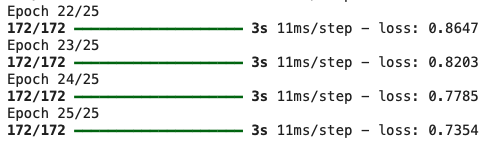

In [ ]:
# Load up the pre-trained RNN model
import gdown
import tensorflow as tf
from tensorflow import keras

file_id = "1ZwGB1d9pHhi_nwsCkDy7KbGOxsiOqjt9"
output_file = "rnn-one-step_25_epochs_students.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

Downloading...
From (original): https://drive.google.com/uc?id=1ZwGB1d9pHhi_nwsCkDy7KbGOxsiOqjt9
From (redirected): https://drive.google.com/uc?id=1ZwGB1d9pHhi_nwsCkDy7KbGOxsiOqjt9&confirm=t&uuid=37c4cfe2-c371-45b2-aac9-fb4b7dd301c5
To: /content/rnn-one-step_25_epochs_students.zip
100%|██████████| 57.8M/57.8M [00:00<00:00, 106MB/s]


'rnn-one-step_25_epochs_students.zip'

In [ ]:
!unzip -qq /content/rnn-one-step_25_epochs_students.zip -d rnn-one-step_25_epochs_students

In [ ]:
# Load the model
#one_step_reloaded = tf.saved_model.load('rnn-one-step/rnn-one-step')
rnn_generator_pt = tf.saved_model.load("/content/rnn-one-step_25_epochs_students/content/rnn-one-step_25_epochs.keras")

In [ ]:
import time

start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = rnn_generator_pt.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
The first shall speed the best seems to her and a
motion; and the place we have stay with him to yours.
In her own lady, that the higher power
We have been was there, who should be usured,
To strengthen that the rides of her kind of
in, Jove loving now is not an earthly learn'd.

WARWICK:
Then God be with the gates of Lord Angelo,
Do as the right revelse warm of men,
Which we may live unsever'd from this land,
Do as the sun upon you.

LEONTES:
Though you have done thee with the office of the city.

PETRUCHIO:
And, in good sweeting, more than tears and serves.
How shalt thou wear'st?

MENENIUS:
Do not like to die?

PETRUCHIO:
And so will I.

DUCHESS OF YORK:
Alas, poor Margaret, 'tis thou to do me.
The king is fill a sin, that you might stay.

RUTLAND:
What, are they? are you are welcome of your blood?

QUEEN ELIZABETH:
The next way say, I love here in this death.

KING RICHARD II:
So may I court, with him, no feel on thought!

GLOUCESTER:
And what shall subject there will I do?


# Resources

**Recommended**:
- Foster, David. 2023. Generative Deep Learning: Teaching Machines to Paint, Write, Compose, and Play. 2nd edition. Beijing Boston Farnham Sebastopol Tokyo: Oreilly & Associates Inc.
  - pp. 129-152
- Chollet, Francois. 2021. Deep Learning with Python. 2nd ed. Manning.
 - pp. 292-304
- Keras RNN Tutorial: https://www.tensorflow.org/text/tutorials/text_generation#generate_text


**Additional**
- Hochreiter, Sepp, and Jürgen Schmidhuber. 1997. “Long Short-Term Memory.” Neural Comput. 9 (8): 1735–80. https://doi.org/10.1162/neco.1997.9.8.1735.
- Karpathy, A. (2015) The Unreasonable Effectiveness of Recurrent Neural Networks. http://karpathy.github.io/2015/05/21/rnn-effectiveness/
